In [3]:
import numpy as np
import pandas as pd

# Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

from numpy.linalg import inv
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh
# bokeh.io.output_notebook()

In [4]:
import Bio

In [5]:
# import biopython stuff 
from Bio.Seq import Seq
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
#from Bio import SearchIO

### Making an example converting fasta entries (already QCd and joined) to a dataframe we can manipulate. Looking at a small file first to test it works (100,000 reads).

In [6]:
from Bio import SeqIO 

def fastq_to_dataframe(file_name):
    "takes in fastq filename as string and puts sequences into pandas dataframe; show first 10 lines to confirm it looks good"
    seqs = []
    for seq_record in SeqIO.parse(file_name, "fastq"):
        info = [seq_record.id, seq_record.seq]
        seqs.append(info)
    df_seqs = pd.DataFrame(seqs, columns = ['ID','DNA_seq'])
    
    return df_seqs

Manually making the dataframe with the 100,000 read file.

In [11]:
seqs = []
for seq_record in SeqIO.parse("subsample_joined.fastq", "fastq"):
    info = [seq_record.id, seq_record.seq]
    seqs.append(info)
df_seqs = pd.DataFrame(seqs, columns = ['ID','DNA_seq'])

#check it's all there
len(df_seqs)

100000

In [12]:
df_seqs.head()

,ID,DNA_seq
0,A00405:272:HJ7FVDSXY:3:2678:9588:8891,"(G, A, G, T, C, A, T, C, T, T, C, G, G, T, T, ..."
1,A00405:272:HJ7FVDSXY:3:2678:9543:33019,"(G, A, G, T, C, A, T, C, T, T, C, G, G, T, T, ..."
2,A00405:272:HJ7FVDSXY:3:2678:9164:21684,"(G, A, G, T, C, A, T, C, T, T, C, G, G, T, T, ..."
3,A00405:272:HJ7FVDSXY:3:2678:8350:16454,"(G, A, G, T, C, A, T, C, T, T, C, G, G, T, T, ..."
4,A00405:272:HJ7FVDSXY:3:2678:8305:31407,"(G, A, G, T, C, A, T, C, T, T, C, G, G, T, T, ..."


### Great. Everything looks good. Now correct the reading frame and translate these. This takes some time for large files.

In [14]:
#go through and delete first base to start @ correct reading frame for CRY
df = df_seqs.copy()

for index in df.index:
    df['DNA_seq'][index] = df['DNA_seq'][index][1:]

NameError: name 'df0' is not defined

In [15]:
df_seqs['DNA_seq'][0], df['DNA_seq'][0] # pre, post (check it worked)

(Seq('GAGTCATCTTCGGTTTTTCCCTTGGGATGCTGATGTTGATAAGTTCAAGGCCTG...ACA'),
 Seq('AGTCATCTTCGGTTTTTCCCTTGGGATGCTGATGTTGATAAGTTCAAGGCCTGG...ACA'))

In [17]:
# We want to translate each sequence and append translated column to dataframe
# First, test one and make sure it's translated correctly.
seq0 = df['DNA_seq'][0]
print(seq0.translate())

SHLRFFPWDADVDKFKAWSQGRTGYPVVDAGMRELWATGWMHNRIRVIVSSFAVKFLLLPWKWGMKYFWDTLLDADLECDFLGWQYISGSIPDGHELDRLD


C:\Users\Sarah\anaconda3\lib\site-packages\Bio\Seq.py:2334: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [19]:
refseq1 = Seq("agtcatcttcggtttttcccttgggatgctgatgttgataagttcaaggcctggagacaaggcaggaccggttatccgttggtggatgccggaatgagagagctttgggctaccggatggatgcataacagaataagagtgattgtttcaagctttgctgtgaagtttcttctccttccatggaaatggggaatgaagtatttctgggatacacttttggatgctgatttggaatgtgacatccttggctggcagtatatctctgggagtatccccgatggccacgagcttgatcgcttggaca")
refseq1.translate(), len(refseq1.translate())
ref_aa_seq = refseq1.translate()
ref_aa_seq

Seq('SHLRFFPWDADVDKFKAWRQGRTGYPLVDAGMRELWATGWMHNRIRVIVSSFAV...RLD')

CRY2(535) translated above lines up correctly with the translated mutagenized region, so now let's go through and translate all sequences and put the translated sequences in the dataframe.

In [21]:
# Declare a list that is to be converted into a column 
aa_seqs = []
for index in df.index:
    translated = df['DNA_seq'][index].translate() # they are already Seq objects
    aa_seqs.insert(index, translated)
df['aa_seq'] = aa_seqs # use 'aa_seq' as the column name and equate it to the list we just added to

In [22]:
df.head()

,ID,DNA_seq,aa_seq
0,A00405:272:HJ7FVDSXY:3:2678:9588:8891,"(A, G, T, C, A, T, C, T, T, C, G, G, T, T, T, ...","(S, H, L, R, F, F, P, W, D, A, D, V, D, K, F, ..."
1,A00405:272:HJ7FVDSXY:3:2678:9543:33019,"(A, G, T, C, A, T, C, T, T, C, G, G, T, T, T, ...","(S, H, L, R, F, F, P, W, D, A, D, V, D, K, F, ..."
2,A00405:272:HJ7FVDSXY:3:2678:9164:21684,"(A, G, T, C, A, T, C, T, T, C, G, G, T, T, T, ...","(S, H, L, R, F, F, P, W, D, A, D, V, D, K, F, ..."
3,A00405:272:HJ7FVDSXY:3:2678:8350:16454,"(A, G, T, C, A, T, C, T, T, C, G, G, T, T, T, ...","(S, H, L, R, F, F, P, W, D, A, Y, V, D, K, F, ..."
4,A00405:272:HJ7FVDSXY:3:2678:8305:31407,"(A, G, T, C, A, T, C, T, T, C, G, G, T, T, T, ...","(S, H, L, R, F, F, P, W, D, A, D, V, D, K, F, ..."


In [30]:
df.to_csv('100000subsample_DNA_AA_seqs.csv')

In [23]:
len(df['aa_seq'][0]), len(ref_aa_seq)

# checking an example sequence in our dataframe matches the reference sequence length

(101, 101)

### Here we are making a new, trimmed down table with mutated sequences info only. An alternate option would be to add new columns to the old dataframe describing the mutations (or NA if wildtype sequence).

In [24]:
data = []

for index in df.index:
    for i in range(0, len(ref_aa_seq)):
        refaa = ref_aa_seq[i]
        r1aa = df['aa_seq'][index][i]
        ID = df['ID'][index]
        if refaa != r1aa:
            mutation_info = [ID, refaa, r1aa, i]
            data.append(mutation_info)
        
df_mutations = pd.DataFrame(data, columns = ['read_ID', 'original_aa', 'mutated_aa', 'position'])

In [79]:
len(df_mutations)

344090

In [27]:
df_mutations.head()

,read_ID,original_aa,mutated_aa,position
0,A00405:272:HJ7FVDSXY:3:2678:9588:8891,R,S,18
1,A00405:272:HJ7FVDSXY:3:2678:9588:8891,L,V,26
2,A00405:272:HJ7FVDSXY:3:2678:9588:8891,I,F,80
3,A00405:272:HJ7FVDSXY:3:2678:9543:33019,K,E,61
4,A00405:272:HJ7FVDSXY:3:2678:9543:33019,I,V,80


In [29]:
df_mutations.to_csv('100000subsample_all_mutations.csv')

### Now make a table of single mutants only.

In [59]:
df_single = df_mutations.copy()

In [60]:
# don't just go through by index. Go through by list of unique values in "read_ID"
df_single = df_single[0:10004]
for val in df_single.read_ID.unique(): #this makes a list of unique vals in this column
    # go through each read and ask how many codon mutations are in the sequence
    num_of_muts = len(df_single[df_single['read_ID'] == val])
    #print(index, num_of_muts)
    if num_of_muts > 1: # if there are more than 1, don't put it in the single mutants table
        df_single = df_single[df_single.read_ID != val] # cuts out those with read_number = val

In [62]:
df_single.to_csv('10000subsample_singlemuts.csv')

In [63]:
df_double = df_mutations.copy()
df_triple = df_mutations.copy()

### Now make a table of double mutants only.

In [64]:
# don't just go through by index. Go through by list of unique values in "read_ID"
df_double = df_double[0:10004]
for val in df_double.read_ID.unique(): #this makes a list of unique vals in this column
    # go through each read and ask how many codon mutations are in the sequence
    num_of_muts = len(df_double[df_double['read_ID'] == val])
    #print(index, num_of_muts)
    if num_of_muts != 2: # if there are not exactly 2 mutations, don't put in the double mutant table
        df_double = df_double[df_double.read_ID != val] # cuts out those with read_number = val

In [66]:
df_double.to_csv('10000subsample_doublemuts.csv')

### Now make a table of triple mutants only.

In [65]:
# don't just go through by index. Go through by list of unique values in "read_ID"
df_triple = df_triple[0:10004]
for val in df_triple.read_ID.unique(): #this makes a list of unique vals in this column
    # go through each read and ask how many codon mutations are in the sequence
    num_of_muts = len(df_triple[df_triple['read_ID'] == val])
    #print(index, num_of_muts)
    if num_of_muts != 3: # if there are not exactly 2 mutations, don't put in the double mutant table
        df_triple = df_triple[df_triple.read_ID != val] # cuts out those with read_number = val

In [67]:
df_triple.to_csv('10000subsample_triplemuts.csv')

## Looking at some basic properties of the data:

In [99]:
sing_perc = 100*len(df_single.read_ID.unique())/len(df_mutations[0:10004].read_ID.unique())
doub_perc = 100*len(df_double.read_ID.unique())/len(df_mutations[0:10004].read_ID.unique())
trip_perc = 100*len(df_triple.read_ID.unique())/len(df_mutations[0:10004].read_ID.unique())

In [362]:
G334 = df_mutations[df_mutations['position'] == 20]
sG334 = df_single[df_single['position'] == 20]
dG334 = df_double[df_double['position'] == 20]
tG334 = df_triple[df_triple['position'] == 20]
len(G334[G334['mutated_aa'] == 'S']), len(sG334[sG334['mutated_aa'] == 'S']), len(dG334[dG334['mutated_aa'] == 'S']), len(tG334[tG334['mutated_aa'] == 'S']), len(df_mutations)

(13905, 0, 1, 1, 344090)

In [379]:
G334 = df_mutations[40000:50000][df_mutations[40000:50000]['position'] == 20]
len(G334[G334['mutated_aa'] == 'S'])

91

In [369]:
df_double[df_double['read_ID'] == 'A00405:272:HJ7FVDSXY:3:2673:18511:11506']

,read_ID,original_aa,mutated_aa,position
908,A00405:272:HJ7FVDSXY:3:2673:18511:11506,G,S,20
909,A00405:272:HJ7FVDSXY:3:2673:18511:11506,I,F,80


## Aside: where did G334S go? 
## Make a table showing all sequences that have at least one G334S mutation.

In [385]:
df_hasG334S = pd.DataFrame({"read_ID": [], "original_aa":[], "mutated_aa":[], 
                        "position": []})
lst = []
G334 = df_mutations[40000:50000][df_mutations[40000:50000]['position'] == 20]
for ID in G334[G334['mutated_aa'] == 'S'].read_ID: # get list of IDs so we can see what else is going on at these sites
    df_to_add = df_mutations[40000:50000][df_mutations[40000:50000]['read_ID'] == ID]
    lst.append(len(df_to_add))
    df_hasG334S = df_hasG334S.append(df_to_add)
    
df_hasG334S = df_hasG334S.reset_index(drop=True) 

Here, we're looking at a 10,000 subset of sequences that came back as having 91 sequences with the G334S mutation. All of these have at least one other mutation present. Let's look at what these are...

In [387]:
print(lst) # shows number of mutations in each sequence with the G334S
# we may want to filter this dataset--24 mutations is probably a bad read.

# just ask for most co-occuring mutation next...

[24, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 3, 4, 2, 4, 2, 2, 4, 4, 1, 2, 3, 3, 3, 3, 3, 1, 2, 4, 2, 1, 8, 3, 5, 3, 3, 6, 6, 6, 2, 2, 4, 4, 3, 4, 3, 2, 1, 2, 1, 5, 4, 3, 5, 5, 4, 2, 4, 2, 3, 3, 2, 4, 5, 4, 4, 3, 4, 2, 3, 3, 2, 4, 3, 3, 2, 4, 2, 2, 3, 4, 2, 3, 2, 1, 3, 16]


In [389]:
df_hasG334S.head()

,read_ID,original_aa,mutated_aa,position
0,A00405:272:HJ7FVDSXY:3:2519:16016:25880,A,D,9.0
1,A00405:272:HJ7FVDSXY:3:2519:16016:25880,K,R,13.0
2,A00405:272:HJ7FVDSXY:3:2519:16016:25880,G,S,20.0
3,A00405:272:HJ7FVDSXY:3:2519:16016:25880,Y,K,24.0
4,A00405:272:HJ7FVDSXY:3:2519:16016:25880,M,L,40.0


In [394]:
# Creating the first Dataframe using dictionary 
df_counts334 = df = pd.DataFrame({"mutated_aa":[], 
                         "count":[], 
                        "position": []})
sorted_positions = df_hasG334S['position'].unique()
sorted_positions.sort() # makes sure it orders from low to high amino acid position (useful for plotting later)
for pos in sorted_positions: # get array of all unique positions that have amino acid substitutions
    df_count = df_hasG334S[df_hasG334S['position'] == pos]['mutated_aa'].value_counts().reset_index()
    df_count.columns = ['mutated_aa','count']
    position = []
    for index in df_count.index:
        position.insert(index, str(pos))
    df_count['position'] = position
    df_counts334 = df_counts334.append(df_count)
df_counts334 = df_counts334.reset_index(drop=True) 

In [404]:
df_counts334[140:145]

,mutated_aa,count,position
140,Q,1.0,81.0
141,W,1.0,82.0
142,L,1.0,83.0
143,R,9.0,84.0
144,L,1.0,84.0


### Shows that it occurs most with Q398R (index 143 above), but no other patterns observed so far...

#### More specifically, in this 10,000 sequence sample, 10% of the time the G334S mutation co-occurs with the Q398R mutation, and this is the most common co-occurance.

## Back to original dataset looking at all mutations and separating by single, double, triple...

In [354]:
print('In this randomly selected 10,000 sequence subsample...')
print(' ')
print('# mutated sequences:', len(df_mutations[0:10004].read_ID.unique()))
print(' ')
print('# single mutants:', len(df_single.read_ID.unique()), '(%.1f%%)' % sing_perc)
print('# double mutants:', len(df_double.read_ID.unique()), '(%.1f%%)' % doub_perc)
print('# triple mutants:', len(df_triple.read_ID.unique()), '(%.1f%%)' % trip_perc)
print(' ')
print('# single L348F mutants:', len(df_single[df_single['position'] == 34]))
print('# double L348F mutants:', len(df_double[df_double['position'] == 34]))
print('# triple L348F mutants:', len(df_triple[df_triple['position'] == 34]))

In this randomly selected 10,000 sequence subsample...
 
# mutated sequences: 3056
 
# single mutants: 1112 (36.4%)
# double mutants: 934 (30.6%)
# triple mutants: 487 (15.9%)
 
# single L348F mutants: 212
# double L348F mutants: 88
# triple L348F mutants: 52


### Now, make sure amino acid position is indexed properly (matches CRY2).

In [104]:
# change indexing to match CRY2
df_single_indexed = df_single.copy()
for index in df_single_indexed.index:
    new_index = df_single_indexed['position'][index] + 314
    df_single_indexed['position'][index] = new_index

<ipython-input-104-a7ca5fbb3e61>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_indexed['position'][index] = new_index


In [107]:
# change indexing to match CRY2
df_double_indexed = df_double.copy()
for index in df_double_indexed.index:
    new_index = df_double_indexed['position'][index] + 314
    df_double_indexed['position'][index] = new_index

<ipython-input-107-503613174459>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_double_indexed['position'][index] = new_index


In [108]:
# change indexing to match CRY2
df_triple_indexed = df_triple.copy()
for index in df_triple_indexed.index:
    new_index = df_triple_indexed['position'][index] + 314
    df_triple_indexed['position'][index] = new_index

<ipython-input-108-5c3c8bb0b857>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_triple_indexed['position'][index] = new_index


In [111]:
df_single_indexed.head()

,read_ID,original_aa,mutated_aa,position
5,A00405:272:HJ7FVDSXY:3:2678:9164:21684,Q,R,398
10,A00405:272:HJ7FVDSXY:3:2678:8250:31407,K,E,368
26,A00405:272:HJ7FVDSXY:3:2678:4824:9126,K,E,368
89,A00405:272:HJ7FVDSXY:3:2678:27245:25003,L,H,371
90,A00405:272:HJ7FVDSXY:3:2678:25183:23218,Q,R,398


## Plotting relative frequency of single mutants.

Text(0.5, 1.0, 'Frequency of Single mutations in CRY2(535) Consitutive Screen in 10,000 subsample (joined, QCed)')

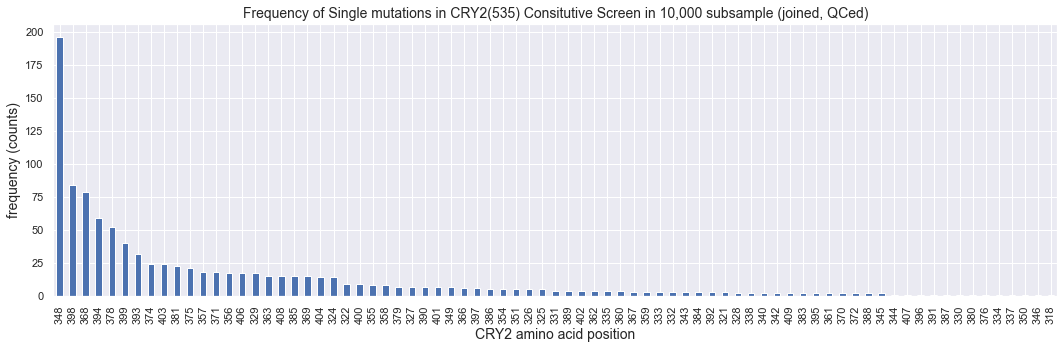

In [119]:
test = df_single_indexed[0:1000]
test['position'].value_counts().plot.bar(figsize=(18,5))
plt.ylabel("frequency (counts)")
plt.xlabel("CRY2 amino acid position")
plt.title("Frequency of Single mutations in CRY2(535) Consitutive Screen in 10,000 subsample (joined, QCed)")

#### Can also look at these single mutants normalized to the most frequent value.

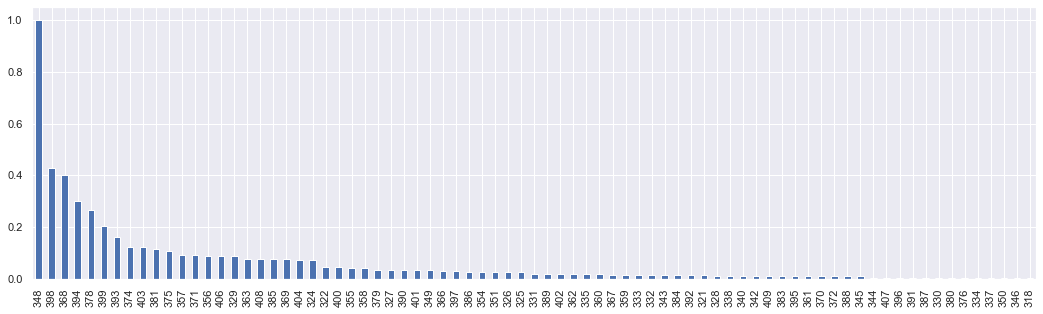

In [342]:
max_val = max(test['position'].value_counts())

norm_data = test['position'].value_counts()/max_val
norm_plot = norm_data.plot.bar(figsize=(18,5))
fig = norm_plot.get_figure()
fig.savefig('normalized_frequencies_single_mutants.png') 

In [232]:
print(df348count)

  mutated_aa  count position
0          F    195     L348
1          H      1     L348


### Now, we can make a table giving the counts of each specific substitution at a given position.

In [322]:
# Creating the first Dataframe using dictionary 
df_counts_final = df = pd.DataFrame({"mutated_aa":[], 
                         "count":[], 
                        "position": []})
sorted_positions = test['position'].unique()
sorted_positions.sort() # makes sure it orders from low to high amino acid position (useful for plotting later)
for pos in sorted_positions: # get array of all unique positions that have amino acid substitutions
    df_count = test[test['position'] == pos]['mutated_aa'].value_counts().reset_index()
    df_count.columns = ['mutated_aa','count']
    position = []
    for index in df_count.index:
        position.insert(index, str(ref_aa_seq[pos-314]+str(pos)))
    df_count['position'] = position
    df_counts_final = df_counts_final.append(df_count)
df_counts_final = df_counts_final.reset_index(drop=True) 

In [388]:
df_counts_final.head()

,mutated_aa,count,position
0,S,1.0,F318
1,R,2.0,W321
2,G,1.0,W321
3,E,6.0,D322
4,G,3.0,D322


In [345]:
df_counts_final.at[0,'count']

1.0

In [349]:
# don't just go through by index. Go through by list of unique values in "read_ID"
df_thresh = df_counts_final.copy()
for ind in df_thresh.index:
    if df_thresh.at[ind, 'count'] < 10:
        df_thresh = df_thresh[df_thresh.index != ind] # cuts out those with read_number = val
df_thresh
df_thresh.to_csv('10000subsample_singlemuts_above10.csv')

In [340]:
dfmatrix = pd.DataFrame({'amino_acid': df_counts_final['mutated_aa'].unique().tolist()})
dfmatrix.set_index('amino_acid', inplace=True)
new_cols = df_counts_final['position'].unique().tolist()
dfmatrix = dfmatrix.reindex(columns = new_cols) 
for ind in dfmatrix.index: # start full of zeros, then we'll add in the counts next
    for col in dfmatrix.columns:
        dfmatrix.at[ind, col] = 0
        
for ind in df_counts_final.index: # adding in the counts! :) 
    mut_aa = df_counts_final.at[ind, 'mutated_aa']
    position = df_counts_final.at[ind, 'position']
    count = df_counts_final.at[ind, 'count']
    dfmatrix.at[mut_aa, position] = count
dfmatrix.to_csv('10000subsample_matrix.csv')

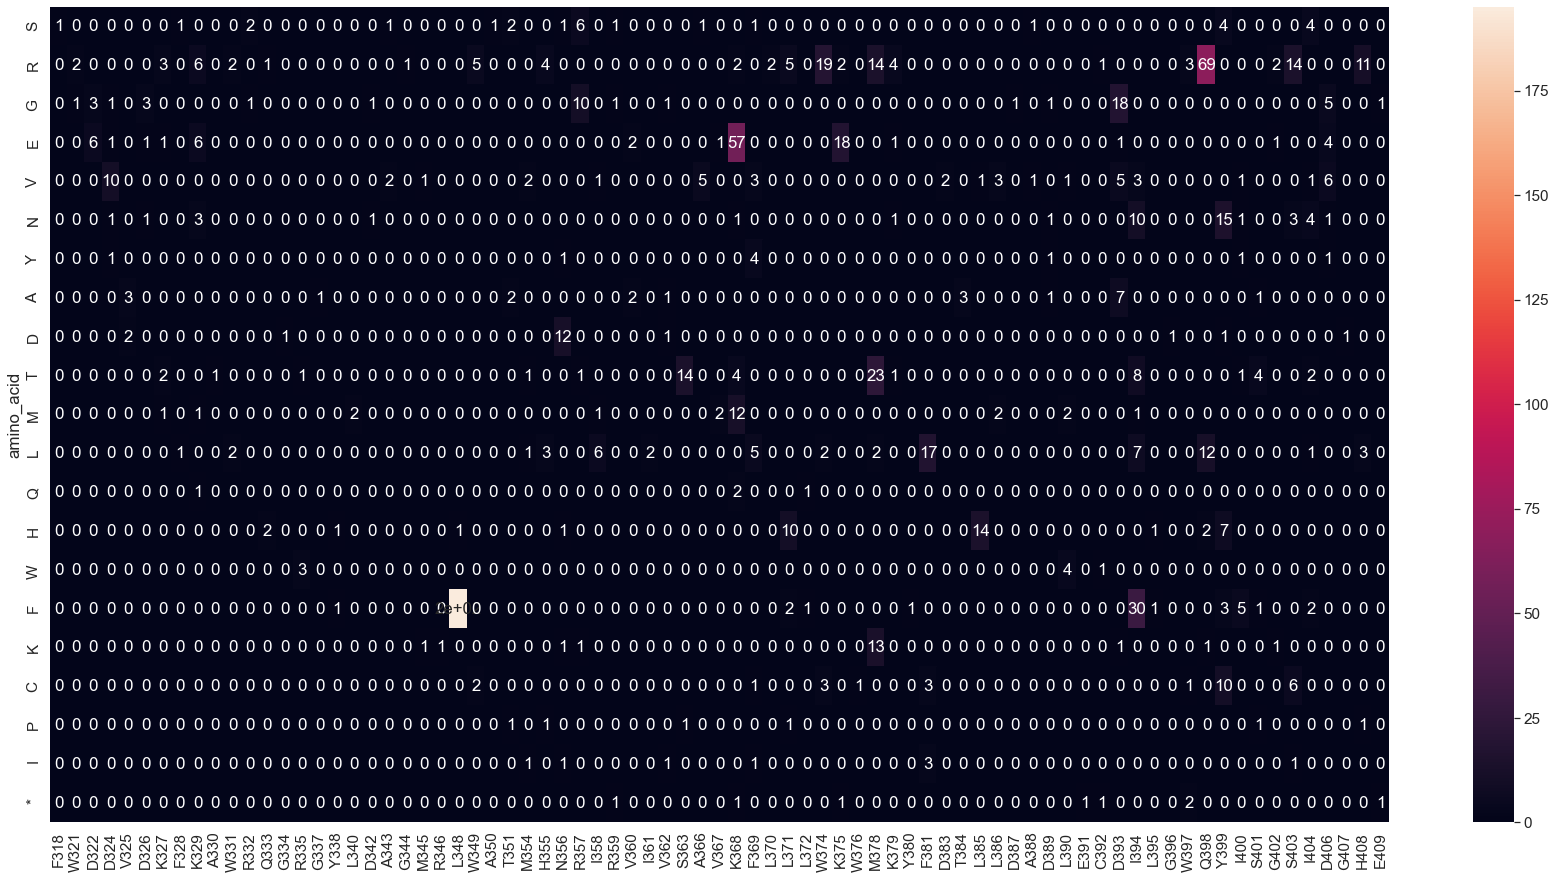

In [343]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (30,15))
sns.set(font_scale=1.4)
plot = sns.heatmap(dfmatrix, annot=True)
fig = plot.get_figure()
fig.savefig('heat_map_mutants.png') 

In [121]:
df_348 = test[test['position'] == 348]
df348count = df_348['mutated_aa'].value_counts().reset_index()
df348count.columns = ['mutated_aa','count']

# add a column keeping the information about the site # and original amino acid
position = []
for index in df348count.index:
    position.insert(index, ref_aa_seq[348-314]+str(348))
df348count['position'] = position # use 'position' as the column name and equate it to the list we just added to
df348count

In [221]:
df_348 = test[test['position'] == 348]
df348count = df_348['mutated_aa'].value_counts().reset_index()
df348count.columns = ['mutated_aa','count']

# add a column keeping the information about the site # and original amino acid
position = []
for index in df348count.index:
    position.insert(index, ref_aa_seq[348-314]+str(348))
df348count['position'] = position # use 'position' as the column name and equate it to the list we just added to
df348count

,mutated_aa,count,position
0,F,195,L348
1,H,1,L348


In [224]:
df_counts_final.append(df348count).append(df348count)

,mutated_aa,count,position
0,F,195.0,L348
1,H,1.0,L348
0,F,195.0,L348
1,H,1.0,L348


In [231]:
print(df348count)

  mutated_aa  count position
0          F    195     L348
1          H      1     L348


In [125]:
df_348['mutated_aa'].value_counts()

# initialize list of lists 
data = [['tom', 10], ['nick', 15], ['juli', 14]] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Name', 'Age']) 

F    195
H      1
Name: mutated_aa, dtype: int64

Text(0.5, 1.0, 'Frequency of various amino acid mutations at 348 normalized to all single mutations at site')

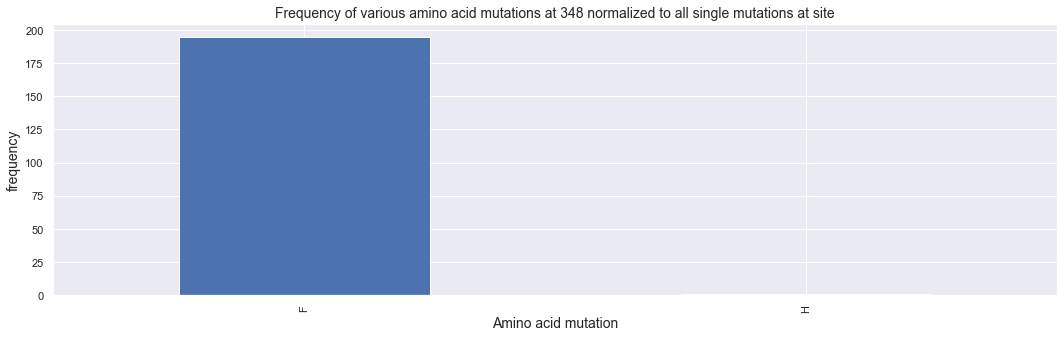

In [122]:
df_348['mutated_aa'].value_counts().plot.bar(figsize=(18,5))

plt.ylabel("frequency")
plt.xlabel("Amino acid mutation")
plt.title("Frequency of various amino acid mutations at 348 normalized to all single mutations at site")

In [123]:
df_348['mutated_aa'].value_counts()

F    195
H      1
Name: mutated_aa, dtype: int64

In [ ]:
test = df_double_indexed[0:1000]
test['position'].value_counts().plot.bar(figsize=(18,5))
plt.ylabel("frequency (counts)")
plt.xlabel("CRY2 amino acid position")
plt.title("Frequency of Double mutations in CRY2(535) Consitutive Screen in 10,000 subsample (joined, QCed)")